In [1]:
import sys
from pathlib import Path

# Path to the root directory of the repository
root_dir = Path().resolve().parent
sys.path.append(str(root_dir / 'src' / 'python'))

import numpy as np
import matplotlib.pyplot as plt
from pybamm import Experiment
import dandeliion.client as dandeliion

# The following lines enable logging output in this notebook
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [2]:
dandeliion.__version__

'1.0.0rc2'

### Authentication
One of the ways to define the simulator object can be the following:

In [3]:
api_url = "http://localhost/v1"
api_key = "some_hash"

simulator = dandeliion.Simulator(api_url, api_key)

# The following sets up a mock simulator (to be used instead of actual simulator for testing)
sys.path.append(str(root_dir / 'tests' / 'python' / 'dandeliion' / 'client'))

# from mock_simulator import MockSimulator
# simulator = MockSimulator(api_url, api_key)

### Parameters
A valid BPX file with battery cell parameters (json-file)

In [4]:
# Can be a file or already read-in valid BPX as dict or BPX object
params = root_dir / 'examples' / 'AE_gen1_BPX.json'

### Experiment
PyBaMM Experiment object, for example:

In [5]:
experiment = Experiment(
    [
        (
            "Discharge at 6 A for 100 seconds",
            "Rest for 10 seconds",
            "Charge at 1 A for 10 seconds",
        ),
        (
            "Discharge at 1 A for 20 seconds",
            "Rest for 10 seconds",
            "Charge at 1 A for 20 seconds",
        ),
    ] * 2,
    period="1 second",  # Optional
)

### Additional model/backend-specific parameters
A dictionary

In [6]:
extra_params = {}

# Number of mesh points in PyBaMM format (default is 16 mesh points everywhere):
extra_params['Mesh'] = {"x_n": 16, "x_s": 8, "x_p": 16, "r_n": 16, "r_p": 16}

# Initial state of charge (default is 1):
extra_params['Initial SOC'] = 1.0

### Calculating solution

In [7]:
solution = dandeliion.solve(
    simulator=simulator,
    params=params,
    experiment=experiment,  # Optional, default is 1C discharge. Translates into the "DandeLiion: Experiment" section
    is_blocking=True, 
    extra_params=extra_params
)

/Users/maximedeckers/opt/anaconda3/envs/dev-env/lib/python3.9/site-packages/pydantic/_internal/_decorators_v1.py:171: UserWarning: The minimum voltage computed from the STO limits (2.4988861558265327 V) is less than the lower voltage cut-off (2.5 V) with the absolute tolerance v_tol = 0.001 V
  model_dict_new = validator(model_dict)


INFO:dandeliion.client.simulator:[running] | 
INFO:dandeliion.client.simulator:[success] | [2025-04-30 14:04:31.668] [info] Total time: 170.714 ms


In [8]:
solution.status

'success'

### Accessing the log file

In [9]:
print(solution.log)

[2025-04-30 14:04:31.497] [info] Starting dandeliion-models v0.1.0...
[2025-04-30 14:04:31.497] [info] Parsing input JSON file parameters.json...
[2025-04-30 14:04:31.499] [info] Input JSON file parsing time: 2.054 ms
[2025-04-30 14:04:31.499] [info] Initialising simulation parameters...
[2025-04-30 14:04:31.500] [info] Title: About:Energy Gen1 Demo 21700 NMC811|graphite 5 Ah cell
[2025-04-30 14:04:31.500] [info] Model: DFN
[2025-04-30 14:04:31.508] [info] Thermal model: Isothermal
[2025-04-30 14:04:31.508] [info] Found DandeLiion Experiment...
[2025-04-30 14:04:31.508] [info] Number of instructions to parse: 12
[2025-04-30 14:04:31.508] [info] Solver mode: Fast (default)
[2025-04-30 14:04:31.508] [info] Simulation parameters initialisation time: 8.559 ms
[2025-04-30 14:04:31.508] [info] Starting the simulation...
[2025-04-30 14:04:31.508] [info] Computational mesh: 15x15 + 7 + 15x15 finite volumes
[2025-04-30 14:04:31.508] [info] Total number of equations: 588
[2025-04-30 14:04:31.508

### Results
Print all available keys in the solution object.
Here method `keys()` is used to get all available keys in the solution object.

In [10]:
for key in sorted(solution.keys()):
    print(key)

Current [A]
Electrolyte concentration [mol.m-3]
Electrolyte potential [V]
Electrolyte x-coordinate [m]
Temperature [K]
Time [s]
Voltage [V]
X-averaged negative electrode exchange current density [A.m-2]
X-averaged negative electrode potential [V]
X-averaged negative electrode surface concentration [mol.m-3]
X-averaged positive electrode exchange current density [A.m-2]
X-averaged positive electrode potential [V]
X-averaged positive electrode surface concentration [mol.m-3]


In [11]:
# Print the final values of time, voltage, and temperature
print(f"Final time [s]: {solution['Time [s]'][-1]}")
print(f"Final voltage [V]: {solution['Voltage [V]'][-1]}")
print(f"Final temperature [K]: {solution['Temperature [K]'][-1]}")

INFO:dandeliion.client.solution:Fetching 'Time [s]' column from simulator
Final time [s]: 340.0
INFO:dandeliion.client.solution:Fetching 'Voltage [V]' column from simulator
Final voltage [V]: 4.113965550630771
INFO:dandeliion.client.solution:Fetching 'Temperature [K]' column from simulator
Final temperature [K]: 298.15


INFO:dandeliion.client.solution:Fetching 'Current [A]' column from simulator


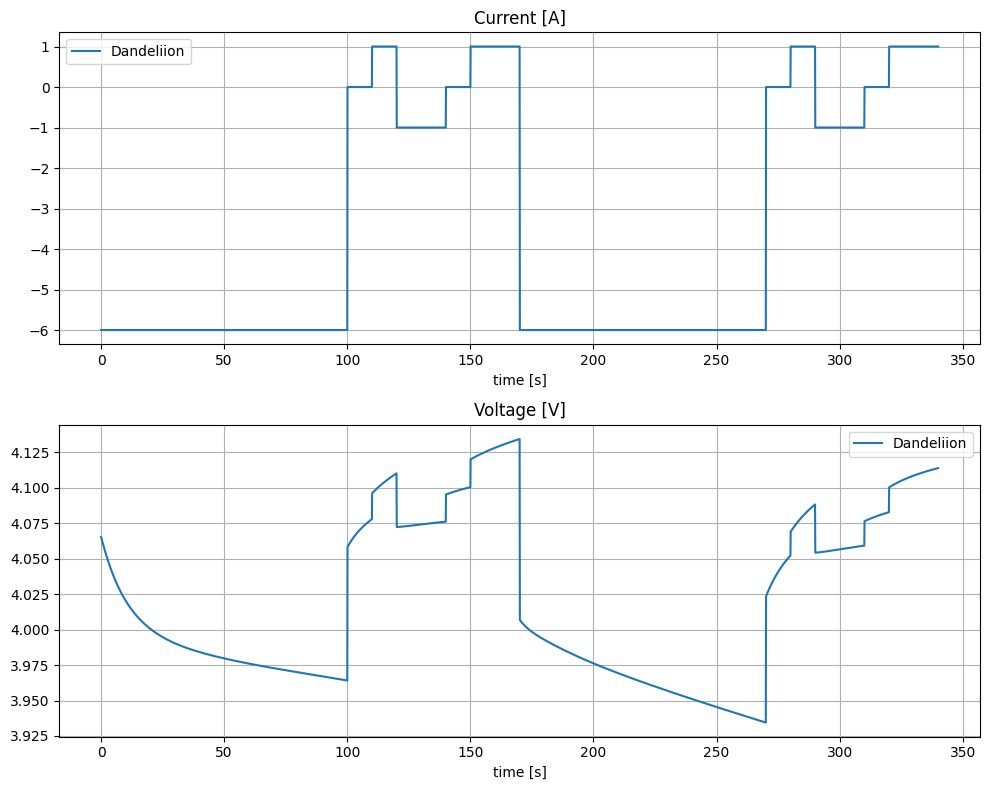

In [12]:
# Plot current and voltage vs time.
# Here we access scalar values vs time.
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(solution["Time [s]"], solution["Current [A]"], label="Dandeliion")
axs[0].set_xlabel("time [s]")
axs[0].set_title("Current [A]")
axs[0].legend()
axs[0].grid()
axs[1].plot(solution["Time [s]"], solution["Voltage [V]"], label="Dandeliion")
axs[1].set_xlabel("time [s]")
axs[1].set_title("Voltage [V]")
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()

INFO:dandeliion.client.solution:Fetching 'Electrolyte x-coordinate [m]' column from simulator
INFO:dandeliion.client.solution:Fetching 'Electrolyte concentration [mol.m-3]' column from simulator


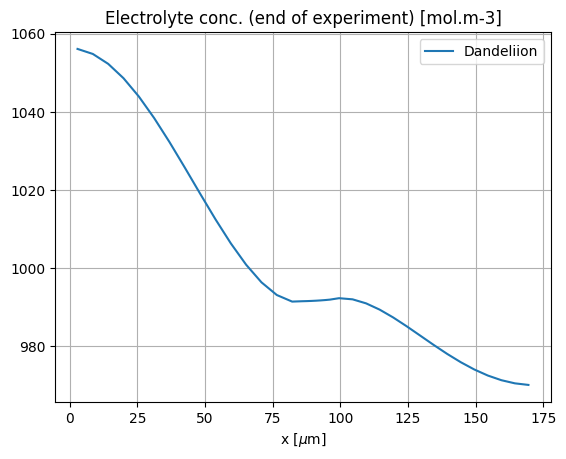

In [13]:
# Concentration in the electrolyte vs `x` at the last time step.
# Here we access spatially dependent values vs time.
plt.plot(
    solution["Electrolyte x-coordinate [m]"] * 1e6,
    solution["Electrolyte concentration [mol.m-3]"][-1],
    label="Dandeliion",
)
plt.xlabel(r"x [$\mu$m]")
plt.title("Electrolyte conc. (end of experiment) [mol.m-3]")
plt.legend()
plt.grid()
plt.show()

In [14]:
solution["Electrolyte x-coordinate [m]"][-1]

0.0001695

In [15]:
# A list of output times (optional)
t_eval = np.arange(0, 3600, 1)

# If the user needs the solution at the `t_eval` times, the following code can be used (works only correctly on columns with timeline data)
# This is a linear interpolation with constant extrapolation
solution["Voltage [V]"](t=t_eval)

array([4.06545644, 4.05908774, 4.0531866 , ..., 4.11396555, 4.11396555,
       4.11396555])